In [54]:
import pandas as pd
data = pd.read_csv('/Users/fipm/code/abefarkas/Thalassa_Regime_Classifier/raw_data/data_set_v2.csv')

In [55]:
data.head(3)

,primary_key,bp1,bs1,bp2,bs2,bp3,bs3,bp4,bs4,bp5,...,ap16,as16,ap17,as17,ap18,as18,ap19,as19,ap20,as20
0,2022-05-19 00:00:00,28700.600000,0.082333,28699.100000,0.017000,28699.000000,1.609667,28697.400000,0.105000,28696.8,...,28704.6,0.268333,28704.833333,0.534333,28704.966667,0.014000,28705.133333,0.027000,28705.300000,0.192000
1,2022-05-19 00:00:01,28700.600000,0.046000,28699.400000,0.012333,28699.033333,0.934000,28697.933333,0.534333,28697.0,...,28704.2,0.207000,28704.366667,0.045667,28704.466667,0.001667,28704.700000,0.101333,28704.866667,0.051000
2,2022-05-19 00:00:02,28695.633333,0.285500,28694.766667,0.077333,28693.733333,0.506000,28693.600000,0.978667,28692.5,...,28702.3,0.885667,28702.400000,0.553333,28702.733333,0.098667,28702.833333,0.001667,28702.966667,0.505333


In [56]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timezone, timedelta
import joblib

class DataModelPipeline():
    def __init__(self):
        self.preprocessing = Pipeline([
            ('Imputer', SimpleImputer(strategy = 'mean')),
            # ('scaler', MinMaxScaler()),
            ])
        self.data = None
        self.y = None
        self.X = None

    def financial_features(self, data):
        self.data = data.copy()

        # unix_timestamp = lambda x: datetime.fromtimestamp(x/1000.0, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
        str2date = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
        # self.data['primary_key']=self.data['ts'].apply(unix_timestamp).apply(str2date)
        self.data['primary_key']=self.data['primary_key'].apply(str2date)
        
        self.data['less30s']=self.data['primary_key'].dt.second<30
        self.data['primary_key']=self.data['primary_key'].dt.strftime('%Y-%m-%d %H:%M')+self.data['less30s'].apply(lambda x: ':15' if x==True else ':45')
        self.data.drop(columns=['less30s'], inplace=True)
        # self.data.drop(columns=['less30s','last_update_id','ts'], inplace=True)

        # WAP
        self.data['WAP'] = (self.data['bp1']*self.data['bs1']
                +self.data['bp2']*self.data['bs2']
                +self.data['ap1']*self.data['as1']
                +self.data['ap2']*self.data['as2'])/(self.data['bs1']+
                                            self.data['bs2']+
                                            self.data['as1']+
                                            self.data['as2'])

        # log_price
        self.data['log_price'] = np.log(self.data['WAP'])

        # log_returns
        self.data['log_returns'] = self.data.log_price.diff()

        # self.data.set_index('primary_key', inplace=True)
        # self.data = self.data.groupby(pd.Grouper(key='primary_key', axis=0, freq='M')).std()
        # print(self.data)
        # self.data['realized_volatility'] = self.data['log_returns']
        # self.data.reset_index(inplace=True)

        # realized_volatility
            # y = self.data[['primary_key','log_returns']]
            # y = y.rolling(30).std()
        sigma = lambda x: (np.nansum(x['log_returns']**2))**0.5
        y = self.data[['primary_key','log_returns']].groupby(['primary_key']).apply(sigma)

        self.data = self.data.groupby(['primary_key']).mean()
        self.data.reset_index(drop=True, inplace=True)
        self.data['volatility']=y.values
            

        return self.data

    def pipeline(self, data):
        data = data.dropna().reset_index(drop=True)
        # self.y = data[['primary_key','realized_volatility']].set_index('primary_key')
        self.y = data[['realized_volatility']]

        X = data.drop(columns=['realized_volatility','primary_key'])
        self.X = pd.DataFrame(self.preprocessing.fit_transform(X), columns=self.preprocessing.get_feature_names_out())
        return self.y, self.X

    def predict(self, model, steps=1):
        # only works for arima
        #n = pd.DataFrame.from_dict({'realized_volatility':new_data})
        #y_new = pd.concat((self.y, n)).reset_index(drop=True)
        new_model = model.apply(self.y)
        predictions = new_model.forecast(steps)
        predictions = pd.DataFrame.from_dict({'realized_volatility':predictions.values})
        y_new = pd.concat((self.y, predictions)).reset_index(drop=True)
        return y_new

In [57]:

data_model_pipeline = DataModelPipeline()
# construct finantial features
df = data_model_pipeline.financial_features(data)
# getting endogenous and exogenous variables to be used
# to train a model
# y, X = data_model_pipeline.pipeline(df)



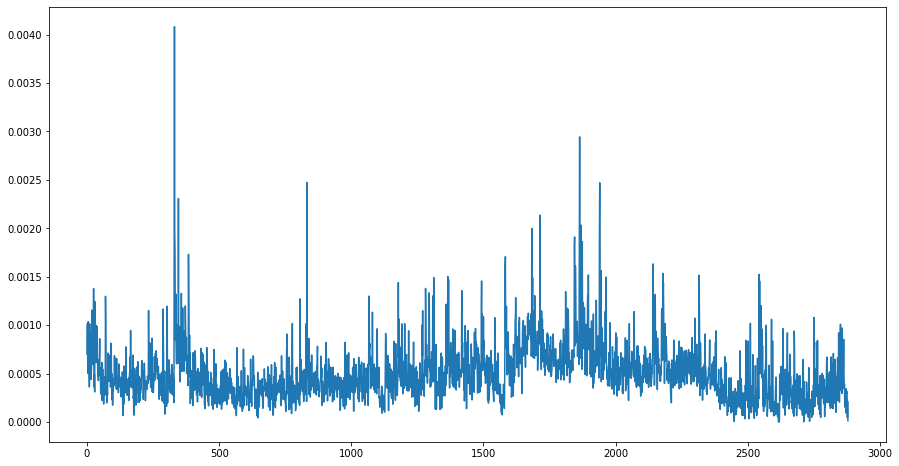

In [58]:
import matplotlib.pyplot  as plt
fig = plt.figure(figsize=(15,8))
plt.plot(df['volatility'])